<a href="https://colab.research.google.com/github/tlcuzick/data-science-projects/blob/main/predicting-car-prices/predicting_car_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math

import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [2]:
headers = [
    'symboling',
    'normalized_losses',
    'make',
    'fuel_type',
    'aspiration',
    'num_doors',
    'body_style',
    'drive_wheels',
    'engine_location',
    'wheel_base',
    'length',
    'width',
    'height',
    'curb_weight',
    'engine_type',
    'num_cylinders',
    'engine_size',
    'fuel_system',
    'bore',
    'stroke',
    'compression_ratio',
    'horsepower',
    'peak_rpm',
    'city_mpg',
    'highway_mpg',
    'price'
]

cars = pd.read_csv('imports-85.data', header=None, names=headers)
cars.head(2)

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500


# **Data Cleaning**

*   Select columns with continuous, numeric values
*   Fill in missing values with the mean from the parent column
*   Normalize feature columns to a 0 to 1 range



In [3]:
cars.replace('?', np.nan)

cols_to_keep = [
    'normalized_losses',
    'wheel_base',
    'length',
    'width',
    'height',
    'curb_weight',
    'engine_size',
    'bore',
    'stroke',
    'compression_ratio',
    'horsepower',
    'peak_rpm',
    'city_mpg',
    'highway_mpg',
    'price'
]

cars = cars[cols_to_keep]

In [4]:
for c in cols_to_keep:
    cars[c] = pd.to_numeric(cars[c], errors='coerce')
    
    avg = cars[c].mean()
    max_val = cars[c].max()
    
    cars[c] = cars[c].fillna(avg)
    cars[c] = cars[c] / max_val

In [5]:
shuffled_rows = np.random.permutation(cars.shape[0])
cars = cars.iloc[shuffled_rows]

cars.head(2)

,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
135,0.406250,0.819686,0.896684,0.919779,0.938127,0.678308,0.371166,0.898477,0.736211,0.404348,0.381944,0.795455,0.428571,0.518519,0.341630
180,0.351562,0.864351,0.902451,0.919779,0.904682,0.770044,0.524540,0.829949,0.803357,0.400000,0.541667,0.787879,0.408163,0.444444,0.345595


# **Train and Test KNN Model**

*  Create a function that trains a KNN model and returns the RMSE
* Create list of RMSE scores by individual feature
* Train and test the KNN model on combinations of the two, three, four, and five best-performing features
* Determine an optimal value of k by training and testing the KNN model across a range of k values from 1 to 25

In [6]:
def knn_train_test(train_cols, target_col, df, k=5):
    num_rows = df.shape[0]
    
    num_train_rows = math.floor(num_rows * 0.75)
    train_set = df[:num_train_rows]
    test_set = df[num_train_rows:]
    
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_set[train_cols], train_set[target_col])
    predictions = knn.predict(test_set[train_cols])
    
    mse = mean_squared_error(test_set[target_col], predictions)
    return mse ** (1/2)

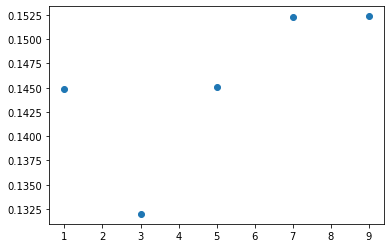

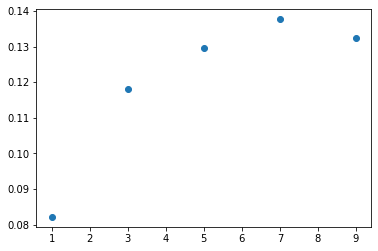

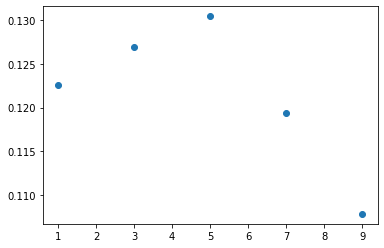

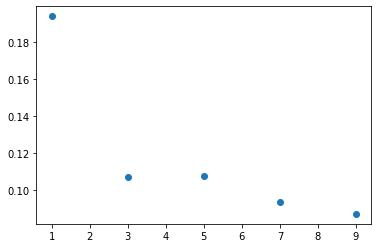

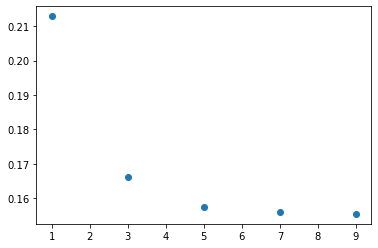

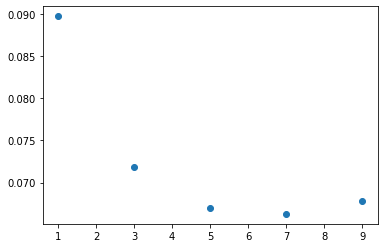

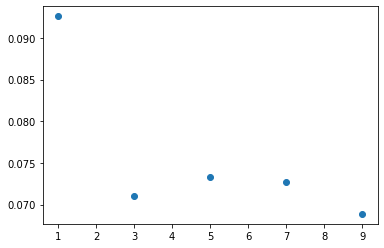

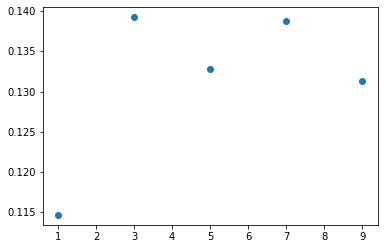

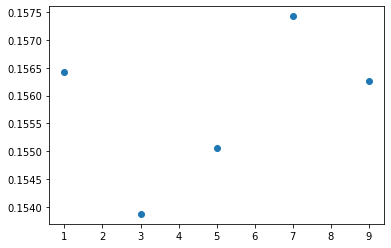

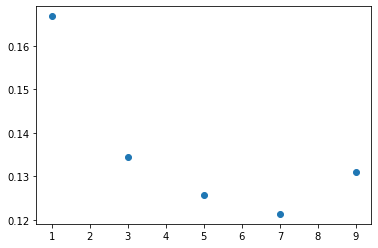

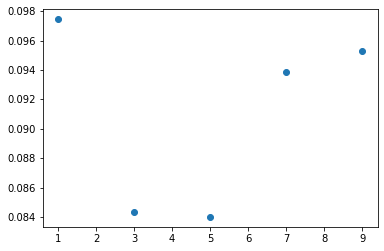

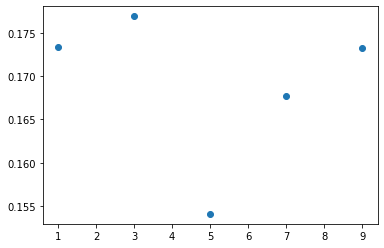

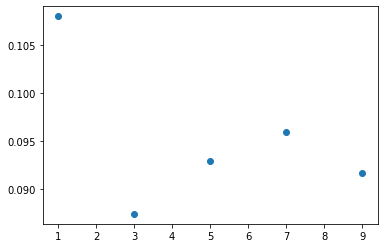

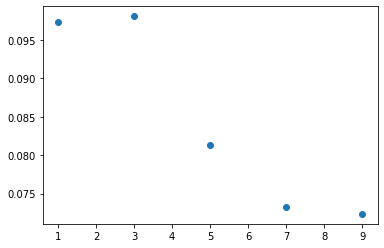

,Feature,RMSE
5,curb_weight,0.072517
6,engine_size,0.075720
13,highway_mpg,0.084454
10,horsepower,0.090995
12,city_mpg,0.095178
3,width,0.117967
1,wheel_base,0.119995
2,length,0.121436
7,bore,0.131344
9,compression_ratio,0.135881


In [7]:
prediction_cols = [x for x in cols_to_keep if x != 'price']
k_values = [1, 3, 5, 7, 9]
results = []

for c in prediction_cols:
    rmses = []
    for v in k_values:
        rmses.append(knn_train_test([c], 'price', cars, v))
    results.append((c, np.mean(rmses)))
    plt.scatter(k_values, rmses)
    plt.show()
                   
results_df = pd.DataFrame(results, columns=['Feature', 'RMSE'])
results_df.sort_values('RMSE', inplace=True)
results_df

In [11]:
best_two_features_rmse = knn_train_test(['engine_size', 'curb_weight'], 'price', cars)
print("Best two features RMSE: {}".format(best_two_features_rmse))

best_three_features_rmse = knn_train_test(['engine_size', 'curb_weight','highway_mpg'], 'price', cars)
print("Best three features RMSE: {}".format(best_three_features_rmse))

best_four_features_rmse = knn_train_test(['engine_size', 'curb_weight','highway_mpg','horsepower'], 'price', cars)
print("Best four features RMSE: {}".format(best_four_features_rmse))

best_five_features_rmse = knn_train_test(['engine_size', 'curb_weight','highway_mpg','horsepower','city_mpg'], 'price', cars)
print("Best five features RMSE: {}".format(best_five_features_rmse))

Best two features RMSE: 0.0629823775699872
Best three features RMSE: 0.06096273827850357
Best four features RMSE: 0.07867895710591279
Best five features RMSE: 0.07580807573438259


In [9]:
def best_k(train_cols, target_col, df, k_vals):
    rmses = []
    for v in k_vals:
        rmses.append(knn_train_test(train_cols, target_col, df, v))
    
    plt.scatter(k_vals, rmses)
    plt.show()
    
    min_rmse = min(rmses)
    min_index = rmses.index(min_rmse)
    return k_vals[min_index]

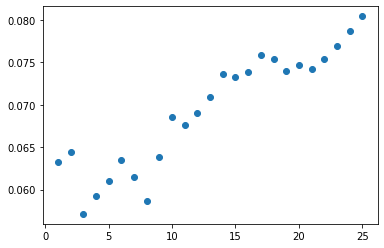

The optimal k value for three features is 3.


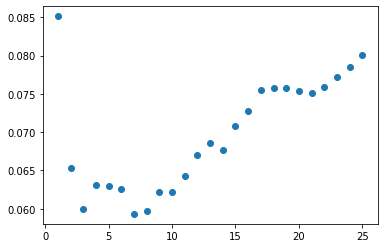

The optimal k value for two features is 7.


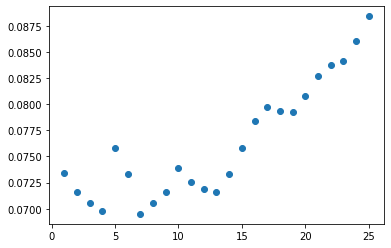

The optimal k value for five features is 7.


In [12]:
k_vals = range(1, 26)

best_k_three_features = best_k(['engine_size', 'curb_weight','highway_mpg'], 'price', cars, k_vals)
print("The optimal k value for three features is {}.".format(best_k_three_features))

best_k_two_features = best_k(['engine_size', 'curb_weight'], 'price', cars, k_vals)
print("The optimal k value for two features is {}.".format(best_k_two_features))

best_k_five_features = best_k(['engine_size', 'curb_weight','highway_mpg','horsepower','city_mpg'], 'price', cars, k_vals)
print("The optimal k value for five features is {}.".format(best_k_five_features))